In [1]:
Stochastic variational deep kernel learning

SyntaxError: invalid syntax (<ipython-input-1-55a7fd8d9c58>, line 1)

In [1]:
%%capture
!pip install gpytorch

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import gpytorch
import tqdm
from torch.utils.data import TensorDataset, DataLoader
import os

from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/Ursa/")

%matplotlib inline
%load_ext autoreload
%autoreload 2

# https://arxiv.org/pdf/1511.02222.pdf

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
all_clusters = np.loadtxt('all_clusters.txt')
all_labs = np.loadtxt('all_labs.txt')
all_labs_cp = np.loadtxt('all_labs_cleaned.txt')
print(all_clusters.shape, all_labs.shape, all_labs_cp.shape)

(694764, 7) (694764,) (694764,)


In [4]:
train_x = all_clusters[all_labs_cp!=-1.]
train_y = all_labs_cp[all_labs_cp!=-1.]

# for i in range(12):
#     train_x = train_x[train_y!=(13. - float(i))]
#     train_y = train_y[train_y!=(13. - float(i))]

train_x = torch.tensor(train_x, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.int64)

# train_y = torch.nn.functional.one_hot(train_y)
# # convert y to one-hot vector for each event
train_y = torch.tensor(train_y, dtype=torch.float32)

print(train_x.shape, train_y.shape)
print(train_x.dtype, train_y.dtype)
# print(train_x[:-10], train_y[:-10])

torch.Size([692025, 7]) torch.Size([692025])
torch.float32 torch.float32


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


In [5]:
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

In [6]:
class MultitaskBernoulliLikelihood(gpytorch.likelihoods.Likelihood):
    def forward(self, function_samples, **kwargs):

#         prob = torch.exp(function_samples)
        prob = function_samples
#         print(prob.shape, prob.dtype)
        output_probs = torch.distributions.Normal(0, 1).cdf(prob)
        out = torch.distributions.Independent(torch.distributions.Bernoulli(probs=output_probs), 1)
#         out = torch.distributions.Independent(torch.distributions.Bernoulli(logits=output_probs), 1)
#         print(out)
    
        return out

In [7]:
class DenseNetFeatureExtractor(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.num_features = 50

        self.net = torch.nn.Sequential(
            torch.nn.Linear(7, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, self.num_features),
            torch.nn.ReLU(),
        )
        pass

    def forward(self, x):
        out = self.net(x)
        return out

num_classes = 13
feature_extractor = DenseNetFeatureExtractor(num_classes=num_classes)
num_features = feature_extractor.num_features
print(num_features, num_classes)

50 13


In [8]:
class GaussianProcessLayer(gpytorch.models.ApproximateGP):
    def __init__(self, num_dim, grid_bounds=(-10., 10.), grid_size=64):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            num_inducing_points=grid_size, batch_shape=torch.Size([num_dim])
        )

        # Our base variational strategy is a GridInterpolationVariationalStrategy,
        # which places variational inducing points on a Grid
        # We wrap it with a IndependentMultitaskVariationalStrategy so that our output is a vector-valued GP
        variational_strategy = gpytorch.variational.IndependentMultitaskVariationalStrategy(
            gpytorch.variational.GridInterpolationVariationalStrategy(
                self, grid_size=grid_size, grid_bounds=[grid_bounds],
                variational_distribution=variational_distribution,
            ), num_tasks=num_dim,
        )
        super().__init__(variational_strategy)

        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(
                lengthscale_prior=gpytorch.priors.SmoothedBoxPrior(
                    math.exp(-1), math.exp(1), sigma=0.1, transform=torch.exp
                )
            )
        )
        self.mean_module = gpytorch.means.ConstantMean()
        self.grid_bounds = grid_bounds

    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

In [9]:
class DKLModel(gpytorch.Module):
    def __init__(self, feature_extractor, num_dim, grid_bounds=(-10., 10.)):
        super(DKLModel, self).__init__()
        self.feature_extractor = feature_extractor
        self.gp_layer = GaussianProcessLayer(num_dim=num_dim, grid_bounds=grid_bounds)
        self.grid_bounds = grid_bounds
        self.num_dim = num_dim

        # This module will scale the NN features so that they're nice values
        self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(self.grid_bounds[0], self.grid_bounds[1])

    def forward(self, x):
        features = self.feature_extractor(x)
        features = self.scale_to_bounds(features)
        # This next line makes it so that we learn a GP for each feature
        features = features.transpose(-1, -2).unsqueeze(-1)
        res = self.gp_layer(features)
        return res

model = DKLModel(feature_extractor, num_dim=num_features)
likelihood = gpytorch.likelihoods.SoftmaxLikelihood(num_features=model.num_dim, num_classes=num_classes)

test_res = model(torch.rand(1024, 7))
print(test_res)

# If you run this example without CUDA, I hope you like waiting!
if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

MultitaskMultivariateNormal(loc: torch.Size([51200]))


In [10]:
from torch.optim.lr_scheduler import MultiStepLR
n_epochs = 5
lr = 0.1
optimizer = torch.optim.Adam(
    [
    {'params': model.feature_extractor.parameters(), 'weight_decay': 1e-4},
    {'params': model.gp_layer.hyperparameters(), 'lr': lr * 0.01},
    {'params': model.gp_layer.variational_parameters()},
    {'params': likelihood.parameters()},
     ],
     lr=lr,
)
scheduler = MultiStepLR(optimizer, milestones=[0.5 * n_epochs, 0.75 * n_epochs], gamma=0.1)
mll = gpytorch.mlls.VariationalELBO(likelihood, model.gp_layer, num_data=len(train_loader.dataset))


def train(epoch):
    model.train()
    likelihood.train()

    minibatch_iter = tqdm.notebook.tqdm(train_loader, desc=f"(Epoch {epoch}) Minibatch")
    with gpytorch.settings.num_likelihood_samples(8):
        for data, target in minibatch_iter:
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(data)
            loss = -mll(output, target)
            loss.backward()
            optimizer.step()
            minibatch_iter.set_postfix(loss=loss.item())

def test():
    model.eval()
    likelihood.eval()

    correct = 0
    with torch.no_grad(), gpytorch.settings.num_likelihood_samples(16):
        for data, target in test_loader:
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
            output = likelihood(model(data))  # This gives us 16 samples from the predictive distribution
            pred = output.probs.mean(0).argmax(-1)  # Taking the mean over all of the sample we've drawn
            correct += pred.eq(target.view_as(pred)).cpu().sum()
    print('Test set: Accuracy: {}/{} ({}%)'.format(
        correct, len(test_loader.dataset), 100. * correct / float(len(test_loader.dataset))
    ))

In [11]:
for epoch in range(1, n_epochs + 1):
    with gpytorch.settings.use_toeplitz(False):
        train(epoch)
        test()
    scheduler.step()
    state_dict = model.state_dict()
    likelihood_state_dict = likelihood.state_dict()
    torch.save({'model': state_dict, 'likelihood': likelihood_state_dict}, 'dkl_cifar_checkpoint.dat')

(Epoch 1) Minibatch:   0%|          | 0/676 [00:00<?, ?it/s]

Test set: Accuracy: 601873/692025 (86.97272491455078%)


(Epoch 2) Minibatch:   0%|          | 0/676 [00:00<?, ?it/s]

Test set: Accuracy: 544756/692025 (78.71912384033203%)


(Epoch 3) Minibatch:   0%|          | 0/676 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

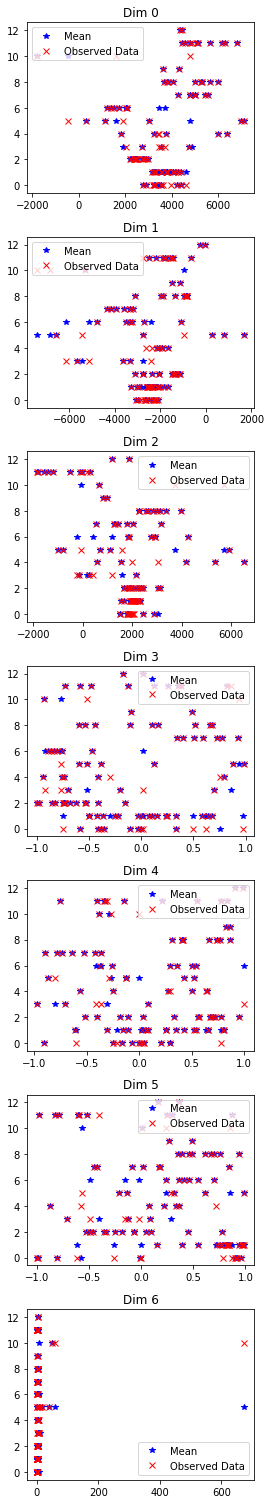

In [12]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
fig, axs = plt.subplots(7, 1, figsize=(4, 3 * 7))
    

with torch.no_grad():
    for x_batch, y_batch in train_loader:
        if torch.cuda.is_available():
                x_batch, y_batch = x_batch.cuda(), y_batch.cuda()
        
        x_batch = x_batch[::10]
        y_batch = y_batch[::10]
        # mean = torch.round(model(x_batch).mean).cpu()
        # mean = (model(x_batch).mean).cpu()
        output = likelihood(model(x_batch))  # This gives us 16 samples from the predictive distribution
        mean = output.probs.mean(0).argmax(-1).cpu()
        
        for xdim in range(7):
            ax = axs[xdim]
            
            ax.plot(x_batch[:, xdim].cpu().detach().numpy(), mean.detach().numpy(), '*b')
            ax.plot(x_batch[:, xdim].cpu().detach().numpy(), y_batch.cpu().detach().numpy(), 'xr', alpha=0.99)
            ax.legend([ 'Mean', 'Observed Data'])
            ax.set_title(f'Dim {xdim}')
        break

fig.tight_layout()
None

(17370, 7) 79937.0


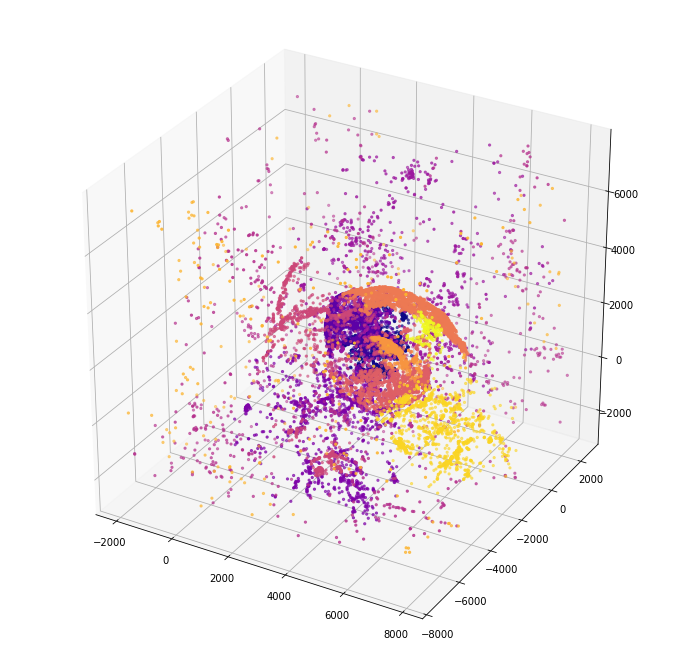

In [13]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

plot_data = all_clusters[::40]
plot_y = all_labs[::40]
print(plot_data.shape, plot_y.sum())
ax.scatter(plot_data.T[0], plot_data.T[1], plot_data.T[2], c=plot_y, marker=".", cmap="plasma")

plt.show()

tensor(0) tensor(12)
(17370, 7) tensor(79286)


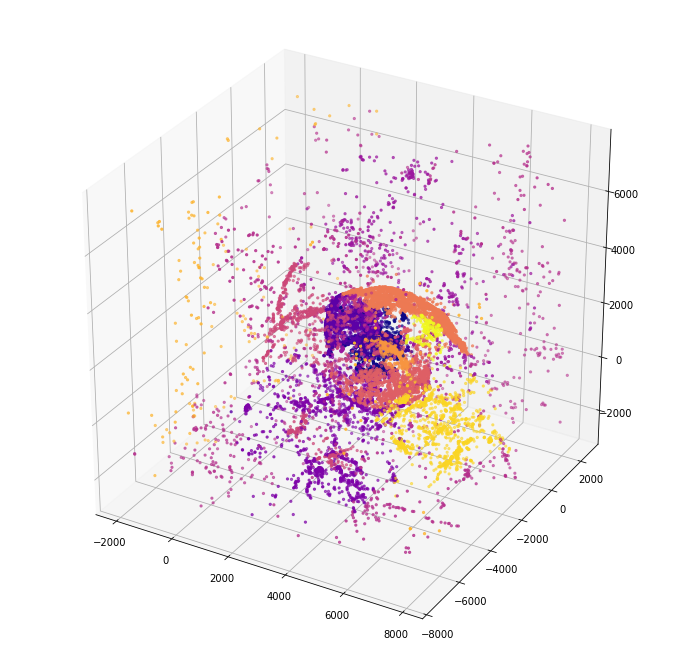

In [14]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

eval_data = torch.tensor(all_clusters[::40], dtype=torch.float32)
if torch.cuda.is_available():
    eval_data = eval_data.cuda()

output = likelihood(model(eval_data))
mean = output.probs.mean(0).argmax(-1).cpu()
plot_y = mean.cpu().detach().numpy()
plot_data = eval_data.cpu().detach().numpy()

print(mean.min(), mean.max())
print(plot_data.shape, mean.sum())
ax.scatter(plot_data.T[0], plot_data.T[1], plot_data.T[2], c=plot_y, marker=".", cmap="plasma")
plt.show()

In [ ]:
# SVGP https://docs.gpytorch.ai/en/stable/examples/04_Variational_and_Approximate_GPs/SVGP_Regression_CUDA.html
# SVGP CLass https://docs.gpytorch.ai/en/stable/examples/04_Variational_and_Approximate_GPs/Non_Gaussian_Likelihoods.html
# DKL Multiclass https://docs.gpytorch.ai/en/stable/examples/06_PyTorch_NN_Integration_DKL/Deep_Kernel_Learning_DenseNet_CIFAR_Tutorial.html
# Exact Dirichlet https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/GP_Regression_on_Classification_Labels.html?highlight=dirichlet

# https://github.com/cornellius-gp/gpytorch/issues/1396